Methods to compute $p_X$ from $p_Z$ and the transform $z = f(x)$:
$$\log p_X(x) = \log p_Z(z) + \log \left( \left| \det \left( \frac{\partial z}{\partial x} \right) \right| \right) $$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
savePath = '/content/gdrive/MyDrive/Phd Courses/Deep learning 02456/Final project/02456_report_template/Plots'

**1-D case study**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal 

Generate data

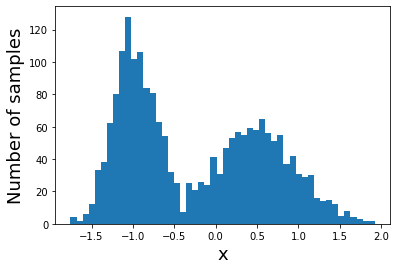

In [ ]:
def CreateRandomDistribution(nx):
  n = nx // 2
  gaussian1 = np.random.normal(loc = -1, scale = 0.25, size = (n,))
  gaussian2 = np.random.normal(loc = 0.5, scale = 0.5, size = (nx-n,))
  px = np.concatenate([gaussian1, gaussian2])
  return px

n_train, n_test = 2000, 1000
train_data = CreateRandomDistribution(n_train)
test_data = CreateRandomDistribution(n_test)

f = plt.figure()
_ = plt.hist(train_data, bins=50)
_ = plt.xlabel('x',fontsize=18)
_ = plt.ylabel('Number of samples',fontsize=18)
plt.savefig(f"{savePath}/Histogram1D.png")


class NumpyDataset(data.Dataset):
  def __init__(self, array):
    super().__init__()
    self.array = array
  
  def __len__(self):
    return len(self.array)
  
  def __getitem__(self, index):
    return self.array[index]

batchsize = 64
train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=batchsize, shuffle = True)
test_loader = data.DataLoader(NumpyDataset(test_data), batch_size=batchsize, shuffle = True)


Create model

In [ ]:
def Transform_x_2_z(x, W, Mu, Sigma):
  distribution = Normal(Mu, Sigma)
  z = (distribution.cdf(x) * W).sum(dim=1)
  dzdx = (distribution.log_prob(x).exp() * W).sum(dim=1)
  return z, dzdx

class CDFNormalizingFlow(nn.Module):
  def __init__(self, K):
    # K: Number of weights (how many CDF's do we use to approx f)
    super(CDFNormalizingFlow, self).__init__()
    # Initialize weights, mus and sigmas randomly
    self.W = nn.Parameter(torch.randn(K), requires_grad=True)
    self.Mu = nn.Parameter(torch.randn(K), requires_grad=True)
    self.Sigma = nn.Parameter(torch.ones(K), requires_grad=True) # initialized as ones so the are non-negative

  def forward(self, x):
    x = x.view(-1,1)
    W = self.W.softmax(dim=0).view(1,-1)
    z, dzdx = Transform_x_2_z(x, W, self.Mu, self.Sigma)
    return z, dzdx

Test on dummy data

In [ ]:
from torch.autograd import Variable
K = 5
NormFlow = CDFNormalizingFlow(K)
x = Variable(torch.from_numpy(train_data[0:batchsize].astype('float32')))
res = NormFlow(x)

Define Loss function and Training/Test loop

In [ ]:
def LossFunction1D(z, dzdx, pZ):
  log_pX = pZ.log_prob(z) + dzdx.log()
  return -log_pX.mean()

def TrainLoop(normflow, train_loader, optimizer, pZ):
  # normflow: Our model
  # pZ: The simple distribution we choose for z
  normflow.train()
  for x in train_loader:
    # x = Variable(torch.from_numpy(train_data[i:i+1].astype('float32')))
    z, dzdx = normflow(x)
    loss = LossFunction1D(z, dzdx, pZ)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def EvaluateLoss(normflow, data_loader, pZ):
  normflow.eval()
  total_loss = 0
  for x in data_loader:
    z, dzdx = normflow(x)
    loss = LossFunction1D(z,dzdx,pZ)
    total_loss = loss*x.size(0)
  # average
  total_loss = total_loss/len(test_loader.dataset)
  return total_loss.item()

Do training and test

In [ ]:
K = 2
lr = 5e-3
epochs = 50

NormFlow = CDFNormalizingFlow(K)
optimizer = torch.optim.Adam(NormFlow.parameters(), lr=lr)
pZ = Normal(0.0, 1.0)

Trainloss = []
Testloss = []
for epoch in range(0,epochs):
  TrainLoop(NormFlow, train_loader, optimizer, pZ)
  # Evaluate training loss at current epoch
  Trainloss.append(EvaluateLoss(NormFlow, train_loader, pZ))
  # Evaluate test loss at current epoch
  Testloss.append(EvaluateLoss(NormFlow, test_loader, pZ))


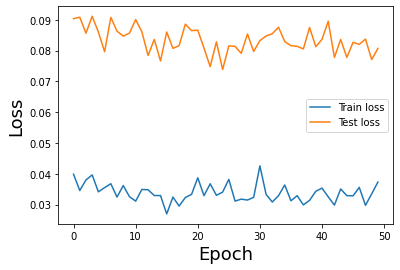

In [ ]:
f = plt.figure()
_ = plt.plot(Trainloss, label='Train loss')
_ = plt.plot(Testloss, label = 'Test loss')
_ = plt.legend()
_ = plt.xlabel('Epoch',fontsize=18)
_ = plt.ylabel('Loss',fontsize=18)
plt.savefig(f"{savePath}/Loss1D.png")

Compute resulting distribution

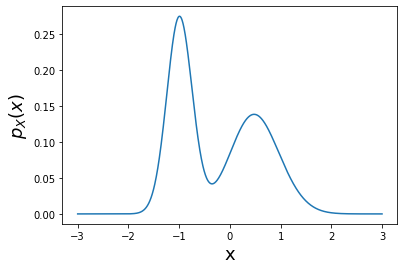

In [ ]:
x = np.linspace(-3,3,1000)
x = torch.FloatTensor(x)
z,dzdx = NormFlow(x)
logpX = pZ.log_prob(z) + dzdx.log()
pX = logpX.exp()

f = plt.figure()
_ = plt.plot(x, pX.detach().numpy())
_ = plt.xlabel('x',fontsize=18)
_ = plt.ylabel('$p_X(x)$',fontsize=18)
plt.savefig(f"{savePath}/pX1D.png")

Transform $z = f(x)$

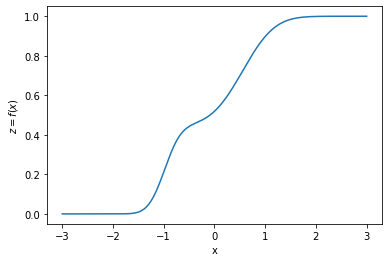

In [ ]:
f = plt.figure()
_ = plt.plot(x,z.detach().numpy())
_ = plt.xlabel('x',fontsize=18)
_ = plt.ylabel('$z=f(x)$',fontsize=18)
plt.savefig(f"{savePath}/Transform1D.png")

**2-D case study**

Fetch data

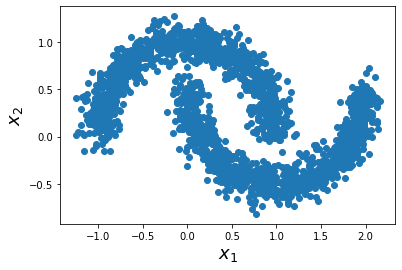

In [ ]:
from sklearn.datasets import make_moons

n_train, n_test = 2000, 1000
train_data2D, train_labels2D = make_moons(n_samples=n_train, noise=0.1)
test_data2D, test_labels2D = make_moons(n_samples=n_test, noise=0.1)

batchsize = 128
train_loader2D = data.DataLoader(NumpyDataset(train_data2D), batch_size=batchsize, shuffle=True)
test_loader2D = data.DataLoader(NumpyDataset(test_data2D), batch_size=batchsize, shuffle=True)

train_data2D.shape
f = plt.figure()
_ = plt.scatter(train_data2D[:,0], train_data2D[:,1])
_ = plt.xlabel('$x_1$',fontsize=18)
_ = plt.ylabel('$x_2$',fontsize=18)
plt.savefig(f"{savePath}/Moons2D.png")

Model, cannot just be z_1 = CDF(x_1), z_2 = CDF(x_2) because then we can never catch the crescent moon shape. So somehow one dimension has to be conditional on the other

In [ ]:
class CDFNormalizingFlow2D(nn.Module):
  def __init__(self, K1, K2, x1_input_size=1, hidden_size=64):
    # K: Number of weights (how many CDF's do we use to approx f(x_1))
    super(CDFNormalizingFlow2D, self).__init__()
    # Find CDF for x_1
    self.get_z1 = CDFNormalizingFlow(K1)

    # Find CDF for x_2 (conditional on x_1)
    self.get_conditional_Mu = nn.Sequential(
        nn.Linear(in_features=x1_input_size, out_features=hidden_size),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=K2)
        )
    
    self.get_conditional_Sigma = nn.Sequential(
        nn.Linear(in_features=x1_input_size, out_features=hidden_size),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=K2)
        )
    
    self.get_conditional_W = nn.Sequential(
        nn.Linear(in_features=x1_input_size, out_features=hidden_size),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.ReLU(),
        nn.Linear(in_features=hidden_size, out_features=K2)
        )
    
  def forward(self, x):
    # separate x into x1 x2
    x1, x2 = torch.chunk(x,2,dim=1)
    x1 = x1.view(-1,1)
    x2 = x2.view(-1,1)

    # Find z1
    z1, dz1dx1 = self.get_z1(x1)

    # Find z2 conditional on x1
    ConditionalW = self.get_conditional_W(x1).softmax(dim=1)
    ConditionalMu = self.get_conditional_Mu(x1)
    ConditionalSigma = self.get_conditional_Sigma(x1).exp() # take exp to ensure nonnegative
    z2, dz2dx2 = Transform_x_2_z(x2, ConditionalW, ConditionalMu, ConditionalSigma)

    # Concatenate
    z = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
    dzdx = torch.cat([dz1dx1.unsqueeze(1), dz2dx2.unsqueeze(1)], dim=1)
    return z, dzdx

Test on dummy data

In [ ]:
K = 5
NormFlow2D = CDFNormalizingFlow2D(K1=K, K2=K)
x = Variable(torch.from_numpy(train_data2D[0:batchsize,:].astype('float32')))
res = NormFlow2D(x)

Define loss function and training loop

In [ ]:
def LossFunction2D(z, dzdx, pZ):
  # log likelihood in each dimension
  log_pX_dim = pZ.log_prob(z) + dzdx.log()
  log_pX = log_pX_dim.sum(1)
  return -log_pX.mean()

def TrainLoop2D(normflow2D, train_loader2D, optimizer2D, pZ):
  # normflow: Our model
  # pZ: The simple distribution we choose for z
  normflow2D.train()
  for x in train_loader2D:
    x = x.float()
    z, dzdx = normflow2D(x)
    loss = LossFunction2D(z, dzdx, pZ)
    optimizer2D.zero_grad()
    loss.backward()
    optimizer2D.step()

def EvaluateLoss2D(normflow2D, data_loader2D, pZ):
  normflow2D.eval()
  total_loss = 0
  for x in data_loader2D:
    x = x.float()
    z, dzdx = normflow2D(x)
    loss = LossFunction2D(z,dzdx,pZ)
    total_loss = loss*x.size(0)
  # average
  total_loss = total_loss/len(test_loader.dataset)
  return total_loss.item()

In [ ]:
K1 = 5
K2 = 5
lr = 5e-3
epochs = 100

NormFlow2D = CDFNormalizingFlow2D(K1=K1, K2=K2)
optimizer2D = torch.optim.Adam(NormFlow2D.parameters(), lr=lr)
zMu = torch.FloatTensor([0,0])
zSigma = torch.FloatTensor([1,1])
pZ2D = Normal(zMu,zSigma)#Normal(zMu, zSigma)

Trainloss2D = []
Testloss2D = []
for epoch in range(0,epochs):
  TrainLoop2D(NormFlow2D, train_loader2D, optimizer2D, pZ2D)
  # Evaluate training loss at current epoch
  Trainloss2D.append(EvaluateLoss2D(NormFlow2D, train_loader2D, pZ2D))
  # Evaluate test loss at current epoch
  Testloss2D.append(EvaluateLoss2D(NormFlow2D, test_loader2D, pZ2D))

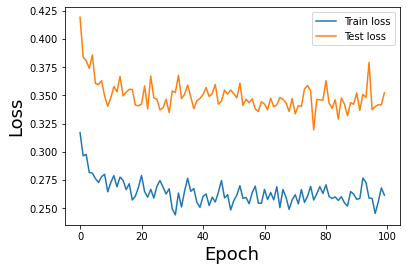

In [ ]:
f = plt.figure()
_ = plt.plot(Trainloss2D, label='Train loss')
_ = plt.plot(Testloss2D, label = 'Test loss')
_ = plt.legend()
_ = plt.xlabel('Epoch', fontsize=18)
_ = plt.ylabel('Loss', fontsize=18)
plt.savefig(f"{savePath}/Loss2D.png")

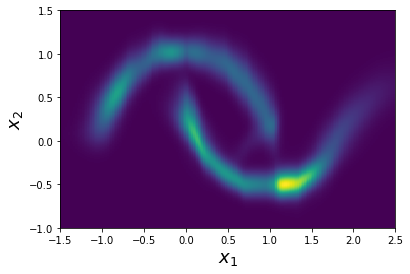

In [ ]:
x1 = np.linspace(-1.5,2.5,200)
x2 = np.linspace(-1,1.5,200)
x1, x2 = np.meshgrid(x1, x2)
x = np.stack([x1, x2], axis=2).reshape(-1,2)
with torch.no_grad():
    z, dzdx = NormFlow2D(torch.FloatTensor(x))
    logpX_2D = pZ2D.log_prob(z) + dzdx.log()
    pX_2D = logpX_2D.sum(1).exp()
    #px = (target_distribution.log_prob(z) + dz_by_dx.log())
    #px = px.sum(1).exp()
    pX_2D = pX_2D.cpu().numpy().reshape(200,200)
    f = plt.figure()
    plt.pcolor(x1,x2,pX_2D)
    plt.xlabel('$x_1$', fontsize=18)
    plt.ylabel('$x_2$', fontsize=18)
    plt.savefig(f"{savePath}/Density2D.png")

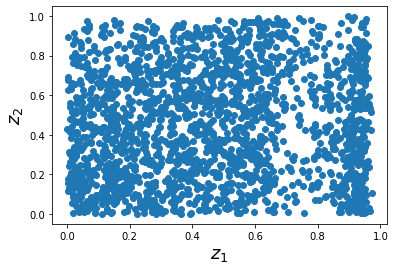

In [ ]:
with torch.no_grad():
    z, _ = NormFlow2D(torch.FloatTensor(train_loader2D.dataset.array))
    z = z.cpu().numpy()
    plt.scatter(z[:,0], z[:,1])
    plt.xlabel('$z_1$', fontsize=18)
    plt.ylabel('$z_2$', fontsize=18)